# what is Eklipse
Eklipse is an advanced AI tool that automatically clips highlights from Twitch, YouTube, Facebook, and Kick streams and videos. <br>
It uses AI to identify exciting moments like kills, clutches, and funny reactions.

In [365]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

#load data 
DATA_PATH = "ds.dataset_raw.csv"
labels = ['user_id', 'total_stream', 'normal_clips', 'downloaded_clips', 'shared_clips', 'edited_clips', 'avg_waiting_time', 'days_active', 'total_spent_minutes', 'join_via', 'days_in_premium', 'churn_status']
def load_data_from_csv(path = DATA_PATH):
    return pd.read_csv(path)

raw_data = load_data_from_csv()
raw_data.head()

,user_id,total_stream,normal_clips,downloaded_clips,shared_clips,edited_clips,avg_waiting_time,days_active,total_spent_minutes,join_via,days_in_premium,churn_status
0,45745320,0,0,0,0,0,0.000000,0,0.000000,Desktop,98,0
1,36485256,4,0,0,0,0,0.000000,0,0.000000,Desktop,36,0
2,52614000,14,551,15,0,23,1.378232,3,135.033333,Desktop,84,0
3,43295328,1,28,0,0,0,0.886389,0,0.000000,Desktop,120,0
4,70911240,1,28,10,0,10,0.770370,6,74.733333,Desktop,16,1


In [366]:
raw_data.info() #the raw data has shape(1000,12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              1000 non-null   int64  
 1   total_stream         1000 non-null   int64  
 2   normal_clips         1000 non-null   int64  
 3   downloaded_clips     1000 non-null   int64  
 4   shared_clips         1000 non-null   int64  
 5   edited_clips         1000 non-null   int64  
 6   avg_waiting_time     1000 non-null   float64
 7   days_active          1000 non-null   int64  
 8   total_spent_minutes  1000 non-null   float64
 9   join_via             1000 non-null   object 
 10  days_in_premium      1000 non-null   int64  
 11  churn_status         1000 non-null   int64  
dtypes: float64(2), int64(9), object(1)
memory usage: 93.9+ KB


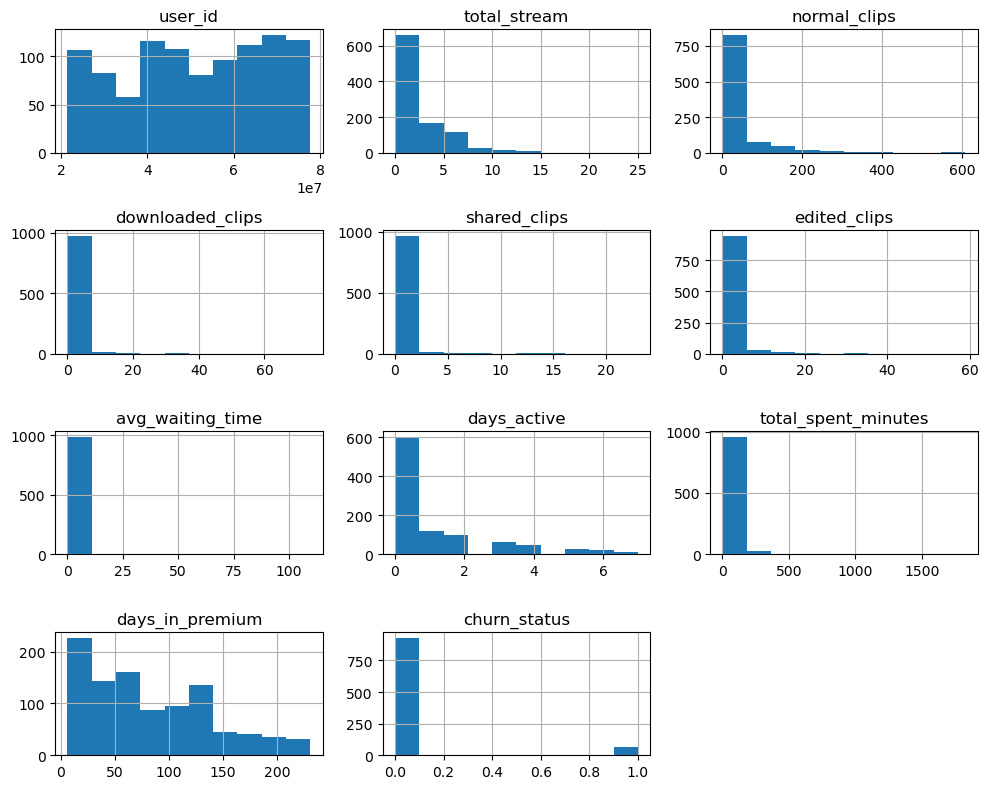

In [367]:
raw_data.hist(figsize=(10,8))
plt.tight_layout()
plt.show()

In [368]:
raw_data["churn_status"].value_counts()

churn_status
0    931
1     69
Name: count, dtype: int64

# first impression 
we see that data are small (1000,12) <br>
no null - blank infor <br>
imbalance <br>
have only one category column <br>
lots of 0 cells so it can be difficult to get a good result <br>

# CLEANING
no blank <br>
noise (cant detect yet!)

Let split the test and the training sets 


In [369]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1,test_size=0.1,random_state=42)
for train_index, val_index in split.split(raw_data, raw_data["churn_status"]):
    strat_train_set = pd.DataFrame(raw_data.loc[train_index])
    strat_test_set = pd.DataFrame(raw_data.loc[val_index])
print(strat_test_set["churn_status"].value_counts()/len(strat_test_set))
print(strat_train_set["churn_status"].value_counts()/len(strat_train_set))

churn_status
0    0.93
1    0.07
Name: count, dtype: float64
churn_status
0    0.931111
1    0.068889
Name: count, dtype: float64


In [370]:
#Then let the test set aside and split train and valid set 
split = StratifiedShuffleSplit(n_splits=1,test_size=0.1)
for train_index, val_index in split.split(strat_train_set, strat_train_set["churn_status"]):
    train_set = pd.DataFrame(raw_data.loc[train_index])
    val_set = pd.DataFrame(raw_data.loc[val_index])
print(val_set.info())

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 133 to 41
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              90 non-null     int64  
 1   total_stream         90 non-null     int64  
 2   normal_clips         90 non-null     int64  
 3   downloaded_clips     90 non-null     int64  
 4   shared_clips         90 non-null     int64  
 5   edited_clips         90 non-null     int64  
 6   avg_waiting_time     90 non-null     float64
 7   days_active          90 non-null     int64  
 8   total_spent_minutes  90 non-null     float64
 9   join_via             90 non-null     object 
 10  days_in_premium      90 non-null     int64  
 11  churn_status         90 non-null     int64  
dtypes: float64(2), int64(9), object(1)
memory usage: 9.1+ KB
None


# Now, lets do feature extraction 
we see that the data doesnt have blank, so we dont need to fill na <br>
we also know that the *join_via* is an object-category datatype, so we need to handle that  <br>

In [371]:
data = train_set.drop("churn_status",axis=1) #we wont use test set so, just rename the train_set to data
data_labels = train_set["churn_status"].copy()
valid_data = val_set.drop("churn_status",axis=1)
valid_labels = val_set["churn_status"].copy()
print(data_labels.value_counts())
print(valid_labels.value_counts())


churn_status
0    752
1     58
Name: count, dtype: int64
churn_status
0    84
1     6
Name: count, dtype: int64


# choose metric and models
I will use f1_score for this problem because this is an imbalanced data
<br>and for models, I will first choose the RandomForest

In [372]:
#at first, we wont add or adjust any columns to see the initial result
num_data = data.drop("join_via",axis=1)
cat_data = data["join_via"].copy()


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin

categorical_columns = ['join_via']
numerical_columns = list(num_data)
numerical_columns.remove("user_id") #we wont use user id because it has no value in predict the churn status
columns_to_drop = ['user_id']
# class DropColumns(BaseEstimator, TransformerMixin): # custome Transformer to drop cols
#     def __init__(self, columns):
#         self.columns = columns

#     def fit(self, X: pd.DataFrame, y=None):
#         return self

#     def transform(self, X: pd.DataFrame):
#         return X.drop(columns=self.columns)
    
coltrans = ColumnTransformer([
    # ('drop_columns', DropColumns(columns_to_drop), columns_to_drop),
    ('onehot', OneHotEncoder(), categorical_columns),
    ('passthrough', 'passthrough', numerical_columns)
])
pipeline_RF = Pipeline([
    ('preprocessor', coltrans),
    ('classifier', RandomForestClassifier())
])
pipeline_RF.fit(data,data_labels)

pred = pipeline_RF.predict(valid_data)
f1 = f1_score(valid_labels.values,pred)
print("pred",pred)
print("ground truth:", valid_labels.values)
print(f1)


pred [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
ground truth: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.1818181818181818


# The answer is clearly overfitting
So we need to finetuning the models <br>
one way is to use **GridSearchCV**

# STILL OVERFITTING
After some adjustment for the pararam_grid, the F1 score is still rly low ~0.13-16! <br>
We need to build a new pipeline then, this time, lets do some feature engineering

In [374]:
#first let see the important features
best_rf = pipeline_RF.named_steps['classifier']
feature_importances = best_rf.feature_importances_
print(feature_importances)
column_transformer = pipeline_RF.named_steps['preprocessor'] #access to CT transformer
onehot_columns = column_transformer.named_transformers_['onehot'].get_feature_names_out(categorical_columns) #get the onehot column names
full_columns = list(onehot_columns) + numerical_columns
# feature_names = ['join_via_App_Android', 'join_via_App_IOS', 'join_via_App_android', 'join_via_Desktop', 'join_via_mobile_Chrome_Android', 'join_via_mobile_Chrome_IOS', 'join_via_mobile_Safari_IOS', 'join_via_mobile_other_Android', 'user_id', 'total_stream', 'normal_clips', 'downloaded_clips', 'shared_clips', 'edited_clips', 'avg_waiting_time', 'days_active', 'total_spent_minutes', 'days_in_premium']

feature_importance_df = pd.DataFrame({'Feature': full_columns, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

[1.97693139e-04 9.06333981e-03 8.42756596e-03 1.24294283e-02
 9.43732727e-03 4.12011857e-03 1.04034863e-02 6.82236846e-04
 1.15004763e-01 8.63063121e-02 1.64434270e-02 8.63136695e-03
 1.99525936e-02 1.51391902e-01 4.80950484e-02 9.86270132e-02
 4.00786378e-01]


,Feature,Importance
16,days_in_premium,0.400786
13,avg_waiting_time,0.151392
8,total_stream,0.115005
15,total_spent_minutes,0.098627
9,normal_clips,0.086306
14,days_active,0.048095
12,edited_clips,0.019953
10,downloaded_clips,0.016443
3,join_via_Desktop,0.012429
6,join_via_mobile_Safari_IOS,0.010403


# Comment on important feature
we clearly see that the days in premium is the one affecting the f1_score the most <br>
Now, let extract and drop some attribs to see will we get better f1_score

In [457]:
categorical_columns = ['join_via']
numerical_columns = list(num_data)

columns_to_drop = ['user_id','shared_clips','downloaded_clips','edited_clips',"normal_clips",'total_spent_minutes','days_active','total_stream'] #we wont use user id because it has no value in predict the churn status
# columns_to_drop = ['user_id'] #we wont use user id because it has no value in predict the churn status
for dropcol in columns_to_drop:
    numerical_columns.remove(dropcol) 
    
    
bin_columns = ['shared_clips','normal_clips','downloaded_clips','edited_clips']
clip_columns = ['shared_clips','normal_clips','downloaded_clips','edited_clips']
avg_columns = ['total_spent_minutes','total_stream','days_active']
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import StandardScaler
class CombinedAttributesAdder(BaseEstimator,TransformerMixin): #this transformer is just a template
    def __init__(self,add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return self

class NumerizeCategoryPipe(BaseEstimator, TransformerMixin):#this transformer is used to change categoty to binary cols (if is target, =1, else = 0)
    def __init__(self, target_column='join_via', target_value='Desktop'):
        self.target_column = target_column
        self.target_value = target_value
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()  # Avoid modifying the original data
        X_copy[self.target_column+'_'+self.target_value] = (X_copy[self.target_column] == self.target_value).astype(int)
        return X_copy[[self.target_column+'_'+self.target_value]]
    def get_feature_names_out(self,input_features=None):
        return [self.target_column+'_'+self.target_value]
        
class IsActivePipe(BaseEstimator, TransformerMixin): #this transfomer is used to check is a value in cols > a threshold (default 0) or not 
    def __init__(self, target_column = None, threshold=0):
        self.target_column = target_column
        self.threshold = threshold
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        self.feature_names = []
        X_copy = X.copy()  # Avoid modifying the original data
        if self.target_column is not None:
            X_copy[self.target_column+"_bin"] = (X_copy[self.target_column] > self.threshold).astype(int)
            return X_copy[self.target_column+"_bin"]
        else:
            for col in X_copy.select_dtypes(include='number'):  
                X_copy[col+"_bin"] = (X_copy[col] > self.threshold).astype(int)
                self.feature_names += [col + "_bin"]
        return X_copy[self.feature_names]
    def get_feature_names_out(self,input_features=None):
        if self.target_column is not None: return [self.target_column+"_bin"] 
        else: return self.feature_names
    
class SumarizeClipPipe(BaseEstimator,TransformerMixin): #this transfomer is used to calculate all the clips cols to one
    def __init__(self,added_clips = None):
        if added_clips is None: self.added_clips = ['shared_clips','normal_clips','downloaded_clips','edited_clips']
        else : self.added_clips = added_clips
        
    def fit(self, X, y=None):
        return self
    def transform(self, X:pd.DataFrame, y=None):
        X['clips'] = X[self.added_clips].sum(axis=1)
        return X[['clips']]
    def get_feature_names_out(self,input_features=None):
        return ["clips"]

class PerDayPipe(BaseEstimator, TransformerMixin): #this transfomer is used to calculate average value per days active
    def __init__(self, perday_cols=['total_spent_minutes', 'total_stream']):
        self.perday_cols = perday_cols
        self.cols_name = [col + '_avg' for col in perday_cols]  # List comprehension

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame, y=None):
        for col, new_col in zip(self.perday_cols, self.cols_name):
            X[new_col] = X[col] / X["days_active"]  # Calculate the average directly
            X[new_col] = X[new_col].replace([np.inf, -np.inf], np.nan) 
            X[new_col].fillna(0, inplace=True)  # Handle potential division by zero

        return X[self.cols_name]

    def get_feature_names_out(self, input_features=None):
        return self.cols_name

num_pipeline = Pipeline([
    ("std_scaler",StandardScaler())
])
clip_pipeline = Pipeline([
    ('summarize_clips', SumarizeClipPipe()),
    ('standardize', StandardScaler())  # Add a StandardScaler step
])
average_pipeline = Pipeline([
    ('perday',PerDayPipe()),
    ('standardize',StandardScaler()),
])
full_pipeline = ColumnTransformer([
    ('avg',average_pipeline, avg_columns),
    ('clip',clip_pipeline,clip_columns),
    ('num', num_pipeline, numerical_columns),
    # ('bin', IsActivePipe(), bin_columns),
    # ('cat', NumerizeCategoryPipe('join_via','Desktop'), ['join_via']),
])
data_prepared = full_pipeline.fit_transform(data,data_labels)
rfc = RandomForestClassifier()


In [505]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'n_estimators': [1, 2,4],
    'max_depth': [5,10,15,25,50],
    'min_samples_split': [2,5,10,15,20],
    'min_samples_leaf': [1, 2,4],
    'bootstrap': [False, True]
}
cv = StratifiedKFold(n_splits=5, shuffle=True) # custom cv to get the stratified valid test
grid_search_RF = GridSearchCV(rfc, param_grid=param_grid, cv=cv, scoring='f1') 
grid_search_RF.fit(data_prepared, data_labels)
best_params_RF = grid_search_RF.best_params_

print("Best parameters for Random Forest:", best_params_RF)
print("Best F1 score for Random Forest:", grid_search_RF.best_score_)
# grid_search_RF = GridSearchCV(rfc, param_grid=param_grid, cv=cv, scoring='roc_auc') 
# grid_search_RF.fit(data_prepared, data_labels)
# best_params_RF = grid_search_RF.best_params_

# print("Best parameters for Random Forest (optimizing for AUC):", best_params_RF)
# print("Best AUC score for Random Forest:", grid_search_RF.best_score_)


Best parameters for Random Forest (optimizing for AUC): {'bootstrap': False, 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 2}
Best AUC score for Random Forest: 0.675664693290521


# The f1 score is improved! 0.16 - 0.2<br>


In [459]:
best_rf_model = grid_search_RF.best_estimator_
feature_importances = best_rf_model.feature_importances_
feature_names = full_pipeline.get_feature_names_out()

feature_importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

print(feature_importances_df)


                        feature  importance
4          num__days_in_premium    0.481663
3         num__avg_waiting_time    0.173706
2                   clip__clips    0.157810
0  avg__total_spent_minutes_avg    0.097347
1         avg__total_stream_avg    0.089474


Use featuree_imporatances and best_estimator_ to see the importances of estimators <br>
After some tests, I decided to use those features above <br>
+ the days_in_premium and avg_waitint_time if from the original data 
+ the clips is from SumarizeClipPipe 
+ the avg feature is from PerDayPipe

# Over sample
now, lets use SMOTE and ADASYN to sample up the data <br>
we still use the same full pipeline and RFC <br>
based on the last GridCV, I can choose the params based on the best F1_score <br>

NOTE: the best parameters will change sometimes (I didnt set seed random), but overall, I will choose those above  <br>
_Hope it work_



In [460]:
prepared_valid_data = full_pipeline.fit_transform(valid_data) 

In [517]:
from sklearn.metrics import f1_score, roc_auc_score

def stratifyValidAverageScore(_data :np.ndarray, _data_labels:pd.Series,_model,_sampler=None,splits = 15,name="Unknown"):
    skf = StratifiedKFold(n_splits=splits, shuffle=True)
    f1_scores = []
    auc_scores = []
    model = _model  # Replace with your desired model
    for train_index, test_index in skf.split(_data, _data_labels):
        X_train, X_test = _data[train_index,:], _data[test_index,:]
        y_train, y_test = _data_labels.iloc[train_index], _data_labels.iloc[test_index]
        if _sampler is not None:
            X_train, y_train = _sampler.fit_resample(X_train,y_train)
        
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        
        y_scores = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (assuming binary classification)
        auc_score = roc_auc_score(y_test, y_scores)
        auc_scores.append(auc_score) 
        
        score = f1_score(y_test, y_pred) 
        f1_scores.append(score)
    val_predict = model.predict(prepared_valid_data)
    val_score = model.predict_proba(prepared_valid_data)[:,1]
    val_f1_score = f1_score(valid_labels,val_predict)
    val_auc_score = roc_auc_score(valid_labels,val_score)
    print(name)
    print("F1 Scores for each fold:", f1_scores)
    print("Average F1 Score:", np.mean(f1_scores))
    print("AUC Scores for each fold:", auc_scores) 
    print("Average AUC Score:", np.mean(auc_scores)) 
    print("F1 Scores for val set:", val_f1_score)
    print("AUC Scores for val set:", val_auc_score) 
    print("")
#the above function is just the same as GridCV, but remember that resampler doesnt have transform, so I need to custom myself
# and, I also calculate the average instead of best and also the auc!

In [518]:
from imblearn.over_sampling import ADASYN,SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC

rfc = RandomForestClassifier(bootstrap=True, max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators= 1)

smote = SMOTE(sampling_strategy = 1,random_state=5)
stratifyValidAverageScore(data_prepared,data_labels,rfc,smote,25,"smote")
borderline = BorderlineSMOTE(sampling_strategy = 1,random_state=5)
stratifyValidAverageScore(data_prepared,data_labels,rfc,borderline,25,"borderlinesmote")
svmsmote = SVMSMOTE(sampling_strategy = 1,random_state=5)
stratifyValidAverageScore(data_prepared,data_labels,rfc,svmsmote,25,"svmsmote")
adasyn = ADASYN(sampling_strategy=1,random_state=5)
stratifyValidAverageScore(data_prepared,data_labels,rfc,adasyn,25,"adasyn")




# grid_search_RF.fit(smote_data, smote_data_labels)
# best_params_RF = grid_search_RF.best_params_

# print("Best parameters for Random Forest:", best_params_RF)
# print("Best F1 score for Random Forest:", grid_search_RF.best_score_)

smote
F1 Scores for each fold: [0.0, 0.22222222222222224, 0.0, 0.5, 0.3333333333333333, 0.14285714285714288, 0.36363636363636365, 0.33333333333333337, 0.0, 0.5, 0.0, 0.2, 0.0, 0.0, 0.3333333333333333, 0.3333333333333333, 0.0, 0.0, 0.0, 0.13333333333333336, 0.22222222222222224, 0.2, 0.0, 0.0, 0.3636363636363636]
Average F1 Score: 0.16724963924963923
AUC Scores for each fold: [0.314516129032258, 0.5483870967741935, 0.37777777777777777, 0.7166666666666666, 0.4444444444444444, 0.4277777777777777, 0.7666666666666666, 0.6222222222222222, 0.31666666666666665, 0.8833333333333333, 0.7833333333333332, 0.775, 0.5333333333333333, 0.3833333333333333, 0.8833333333333333, 0.65, 0.3916666666666667, 0.475, 0.575, 0.5166666666666666, 0.775, 0.5833333333333334, 0.25, 0.4833333333333333, 0.8499999999999999]
Average AUC Score: 0.5730716845878135
F1 Scores for val set: 0.058823529411764705
AUC Scores for val set: 0.4305555555555556

borderlinesmote
F1 Scores for each fold: [0.17391304347826084, 0.0, 0.0, 0.

# f1_score on val is about 18-20 while the auc is about 60-65
actually, not top good, but for this dataset, I think this result is acceptable! <br>
And look at the AUC and F1 scores of val set, its  very low compared to the means from trains set cross validation! 

# The final result on test set
I will choose the same full pipeline and the resampler will be borderlineSMOTE <br>
Lets see the final result 

In [463]:
test_data = strat_test_set.drop("churn_status",axis=1)
test_data_labels = strat_test_set["churn_status"].copy()
train_data = strat_train_set.drop("churn_status",axis=1)
train_data_labels = strat_train_set["churn_status"].copy()
rfc = RandomForestClassifier(bootstrap=True, max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators= 1)


In [516]:
X = full_pipeline.fit_transform(train_data,train_data_labels)
y = train_data_labels
X1 = full_pipeline.fit_transform(test_data)
y1 = test_data_labels
X, y = borderline.fit_resample(X,y)
rfc.fit(X,y)
y_pred = rfc.predict(X1)
y_scores = rfc.predict_proba(X1)[:, 1]
auc_score = roc_auc_score(y1, y_scores)        
f1_scr = f1_score(y1, y_pred) 
print(f"{auc_score = }")
print(f"{f1_scr = }")

auc_score = 0.5468509984639016
f1_scr = 0.12121212121212123


# CONCLUSION
this dataset is really hard! <br>
its small, imbalance, and most of all, the pattern is not easy to find!! <br>
As you can see, my final is really different from the Cross validation of Train set. (unstable) <br>
You can try to run the final-result cell many times, you will see that the result fluctuates from 0.5 -> 0.6 for auc and 0.1 -> 0.18 for f1 <br>
There are many others models, but I will choose RandomForest because its familiar with me (hehe) <br>
You can also see the code python in main.py and also the steps I go through in search.ipynb 